In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [2]:
SIZE = "large"  # model size: choose from {'small', 'base', 'large'}
CTX = 100  # context length: any positive integer
PDT =  68
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer


# 1. Forecasting with Moirai

Given a time series, Moirai (prediction model) use the context window as input and outputs a prediction window. So, the user need to set the **context_length** and **prediction_length** in advance. 

For time series data, the information contained within a single timestamp is not rich enough. Therefore, we refer to consecutive time points as 'patches', forming the basic units of Moirai input (similar to the concept of word token in Language Models). Moirai provides various ***patch_size*** [8, 16, 32, 64, 128].

Additionally, users need to select the **model size** ('small', 'base', 'large') of Moirai for prediction, along with the **batch_size**, which determines the number of samples that can be inferred in parallel. Since Moirai supports probablistic forecast, users should specify the **num_samples**, indicating the number of times it has to sample the forecasting distribution.

In [3]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=32,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)


In [4]:
# prepare a long panads dataframe for the model
def prepare_for_moirai_long_dataframe(df, ctx, bsz,pdt):
    newdata = rearrange(df["target"].to_numpy()[:ctx*bsz], "(b c) -> b c", b=bsz, c=ctx)
    start_dates = df.index[:ctx*bsz:ctx].to_period("D")
    inp = {
        "target": newdata,
        "start": start_dates,
        "feat_static_cat": np.array([0]*bsz)
    }


    # create an array of label data by looping over in batch data and filing the label with the next CTX values
    newlabeldata = np.zeros(shape=(bsz, pdt))
    newstart = np.zeros(bsz, dtype=type(df.index[ctx].to_period(freq="D")))
    for i in range(bsz):
        newlabeldata[i,:] = df["target"].to_numpy()[(i+1)*ctx:(i+1)*ctx+pdt]
        if i < bsz-1:
            newstart[i] = start_dates[i+1] #df.index[i*(CTX+1)].to_period("D")
        else:
            newstart[i] = df.index[ctx*bsz+1].to_period("D")

    # create a sample for the hourly data, using one week data as context window and predicting the next two days.
    label = {
        "target": newlabeldata, 
        "start": newstart,
    }
    
    # Time series values for gluonts with shape (batch, time, variate)
    past_target = rearrange(
        torch.as_tensor(inp["target"], dtype=torch.float32), "b c -> b c ()"
    )
    # 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
    past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
    # 1s if the value is padding, 0s otherwise. Shape: (batch, time)
    past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

    return inp,label,past_target,past_observed_target,past_is_pad

In [5]:
# prepare a long panads dataframe for the model
def prepare_for_moirai_wide_dataframe(df, bsz, ctx,pdt):

    # this function will use the most recent data for the context window and predict the next pdt values

    # extract all rows for all columns that start with target_i
    # Filter columns that start with 'target_i'
    filtered_df = df.filter(regex='^target_')

    # Convert the filtered DataFrame to a NumPy array
    numpy_array = filtered_df.to_numpy()
    newdata = numpy_array[-ctx-pdt:-pdt,:].T
    # newdata = rearrange(numpy_array[:ctx,:].T, "(b c) -> b c", b=bsz, c=ctx)
    # make an array of equal start dates for the batch
    start_dates = np.full(bsz,df.index[-ctx-pdt].to_period("D"))
    
    inp = {
        "target": newdata,
        "start": start_dates,
        "feat_static_cat": np.array([-ctx-pdt]*bsz)
    }


    # create an array of label data by looping over in batch data and filing the label with the next CTX values
    newlabeldata = np.zeros(shape=(bsz, pdt))
    newstart = np.full(bsz,df.index[-pdt].to_period("D"))
    newlabeldata = numpy_array[-pdt:,:].T
    print(newlabeldata.shape)
    # create a sample for the hourly data, using one week data as context window and predicting the next two days.
    label = {
        "target": newlabeldata, 
        "start": newstart,
    }
    
    # Time series values for gluonts with shape (batch, time, variate)
    past_target = rearrange(
        torch.as_tensor(inp["target"], dtype=torch.float32), "b c -> b c ()"
    )
    print(past_target.shape)
    # 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
    past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
    # 1s if the value is padding, 0s otherwise. Shape: (batch, time)
    past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

    return inp,label,past_target,past_observed_target,past_is_pad

In [6]:
# plot the forecasted data
def plot_moirai(inp, label, forecast,field,fname):

    # get batch from the input shape (batch, time, variate)
    BSZ = inp["target"].shape[0]
    # get CTX from the input shape (batch, time, variate)
    CTX = inp["target"].shape[1]
    # get PDT from the label shape (batch, time, variate)
    PDT = label["target"].shape[1]

    # calculate the number of subplots based on the batch size and 2 columns
    ncols = 2
    # calculate the number of rows, up to 10 rows
    nrows = min(BSZ//ncols,10)
    bsz2 = ncols*nrows

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 30))
    axes = axes.flatten()

    for i in range(bsz2):
        ax = axes[i]

        # create a time array for the x-axis
        time_steps = np.arange(0, len(inp["target"][i])+len(label["target"][i]))
        
        # concatenate the input and label data
        crap=np.concatenate([inp["target"][i,:],label["target"][i]])
        #
        # Plot input data
        ax.plot(time_steps,crap, label='Input', color='black')
        
        
        # Plot 0.5 and 0.9 percentiles
        lower_percentile = np.percentile(forecast[i], 5, axis=0)
        upper_percentile = np.percentile(forecast[i], 95, axis=0)
        ax.fill_between(time_steps[CTX:CTX+PDT], lower_percentile, upper_percentile, color='blue', alpha=0.3, label='0.5-0.9 Percentile')


        # # Plot forecasted data
        median_forecast = np.median(forecast[i], axis=0)
        ax.plot(time_steps[CTX:CTX+PDT],median_forecast, label='Forecast (Median)', color='orange',linewidth=2)
        
        ax.grid(True)
        
        ax.set_title(f'{field} {i+1}')
        ax.legend()

    # Hide any unused subplots
    for j in range(BSZ, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f"./plots/{fname}.png")
    plt.savefig(f"./plots/{fname}.svg")
    plt.show()

    # save the input, label and forecast data into a single data frame
    df_forecast = pd.DataFrame()
    for i in range(BSZ):
        Nlen = len(np.arange(0, len(inp["target"][i])+len(label["target"][i])))
        crap_array = np.full(Nlen, np.nan)
        crap_array[CTX:CTX+PDT] = np.median(forecast[i], axis=0)
        crap_arrayL = np.full(Nlen, np.nan)
        crap_arrayL[CTX:CTX+PDT] = np.percentile(forecast[i], 5, axis=0)
        crap_arrayU = np.full(Nlen, np.nan)
        crap_arrayU[CTX:CTX+PDT] = np.percentile(forecast[i], 95, axis=0)
        df_forecast = pd.concat([df_forecast, pd.DataFrame({
            "time": np.arange(0, len(inp["target"][i])+len(label["target"][i])),
            "input": np.concatenate([inp["target"][i,:],label["target"][i]]),
            "forecast": crap_array,
            "lower_percentile": crap_arrayL,
            "upper_percentile":crap_arrayU ,
            "label": np.concatenate([np.full(CTX, np.nan),label["target"][i]])
        })], axis=0)
    df_forecast.to_csv(f"./plots/{fname}.csv", index=False)


## 1. Earthquake catalogs

     datetime  count
0  2008-01-01    120
1  2008-01-02     89
2  2008-01-03    146
3  2008-01-04    166
4  2008-01-05     94
total length: 3653
time frequency: 1 days 00:00:00


<Axes: xlabel='datetime'>

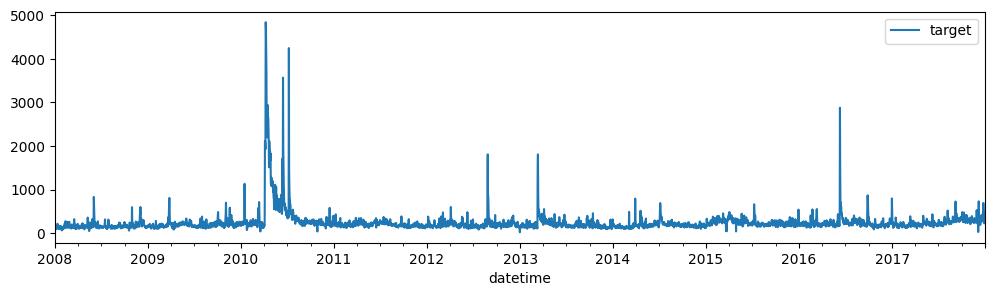

In [7]:
# Load dataframe and plot it
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")
print(df.head())
# move datetime as index of the dataframe
df["datetime"] = pd.to_datetime(df["datetime"])
# rename count to target
df = df.rename(columns={"count": "target"})
df = df.set_index("datetime")
# df = df[df["item_id"] == "A"].drop(columns=["item_id"])
print(f"total length: {df.shape[0]}")
print(f"time frequency: {df.index.diff()[1]}")
df.plot(figsize=(12, 3))


In [8]:
#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df)-PDT)//CTX
print(f"batch size: {BSZ}") 

batch size: 11


In [9]:
# prepare data for moirai
#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df)-PDT)//CTX
print(f"batch size: {BSZ}") 
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_long_dataframe(df, CTX, BSZ,PDT)


In [10]:
past_is_pad.shape

torch.Size([11, 300])

In [11]:
# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
print(forecast.shape,CTX,PDT,BSZ)

torch.Size([11, 100, 68]) 300 68 11


In [12]:
print(
    "median prediction:\n",
    np.round(np.median(forecast[1], axis=1), decimals=4),
)
print("ground truth:\n", label["target"][1])

median prediction:
 [152.5806 146.165  163.5212 150.9069 148.9087 150.7375 160.6049 154.0496
 160.0896 148.0652 142.9488 160.8815 142.0288 146.9809 159.4523 158.6118
 148.4313 134.0107 153.2756 153.6594 156.0004 148.6446 145.6053 156.2354
 158.249  163.0375 158.0948 147.967  161.9932 153.4044 163.1466 149.9298
 150.2997 163.0703 144.7532 158.3188 170.2328 156.6327 151.1009 152.154
 152.3445 153.4848 144.9408 166.218  159.9474 164.784  138.6566 158.5856
 151.8821 153.3818 152.7808 151.2271 148.9342 149.0849 155.3007 155.6542
 147.3072 154.3304 147.7582 141.0155 168.6974 156.4169 150.1542 147.8456
 147.3775 150.5076 150.974  150.4851 145.316  152.2012 156.8279 155.9916
 163.0992 153.4549 147.6415 150.2178 155.8692 159.8189 146.211  152.67
 151.9592 156.6185 160.3741 150.3891 156.2466 149.7159 176.4189 161.1452
 157.1265 178.4458 153.2185 160.876  156.2486 156.3859 156.0008 150.0604
 156.761  154.964  160.1057 160.9458]
ground truth:
 [164. 132. 167. 599. 220. 246. 205. 159. 153. 114. 129

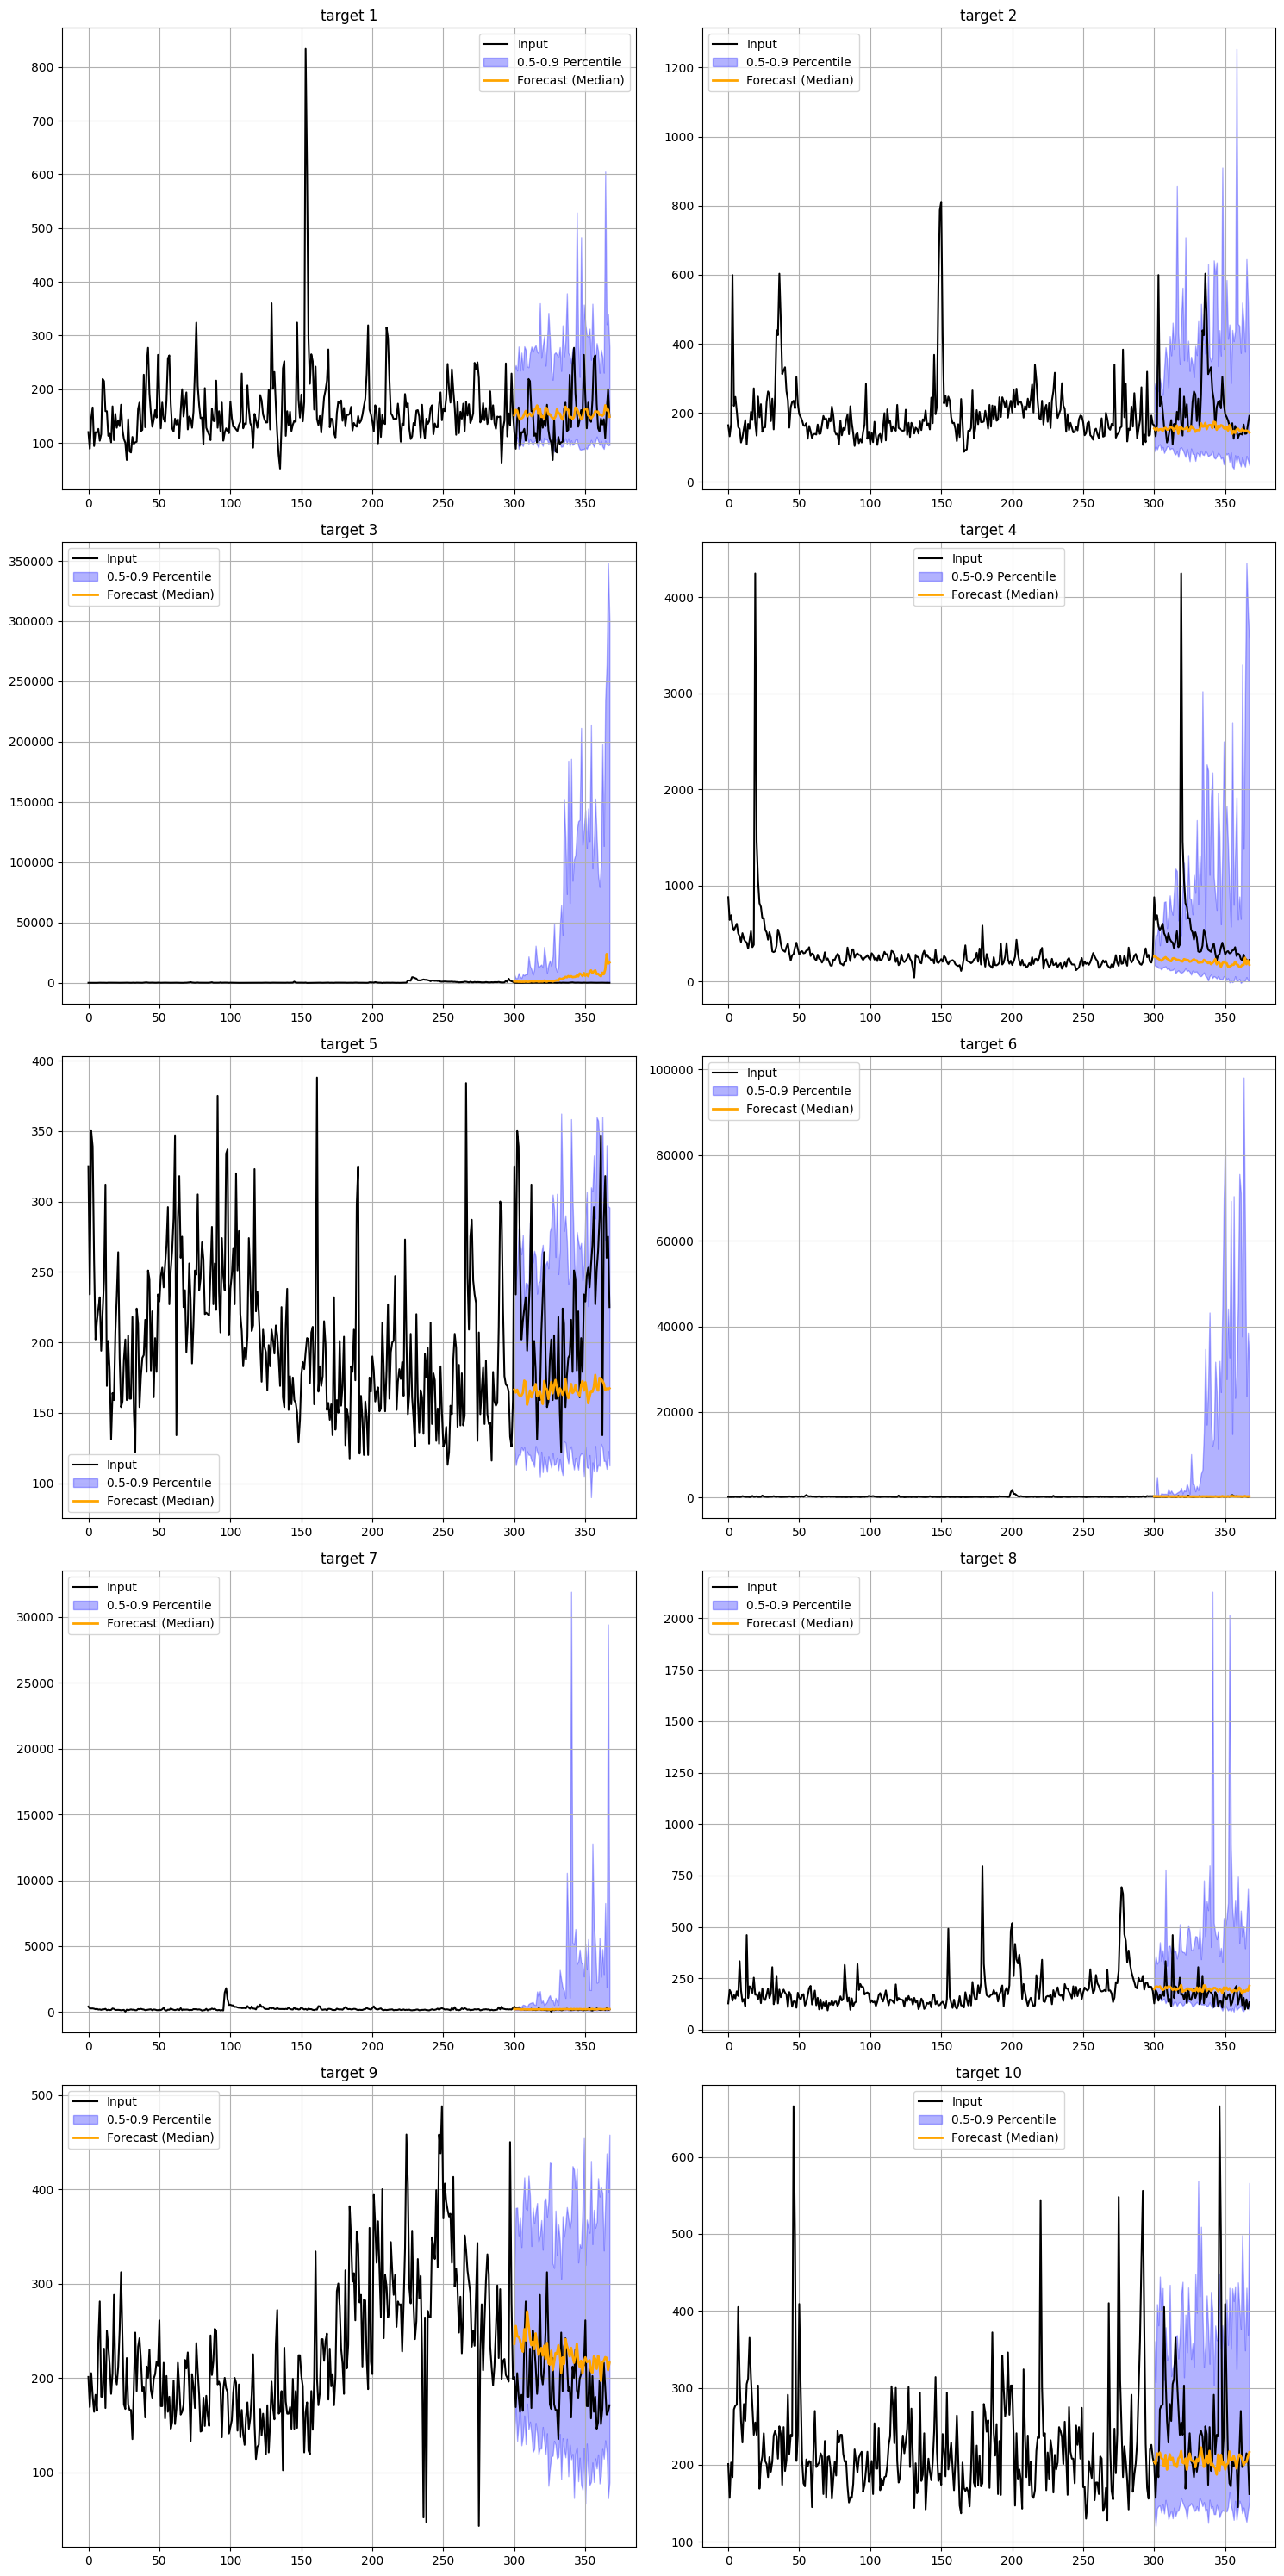

In [13]:
plot_moirai(inp, label, forecast,"target","moirai_forecast")

## 2. Icesheet velocities

Now we test the time series of icesheet velocities in Greenland. This is work done by Brad Lipovsky.

In [14]:

'''
Read the data
'''
df = pd.read_csv('../data/data_ice_jakobshavn.csv',na_values=[-1])


In [15]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["Date"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print("sampling rate {} days".format(dt))

sampling rate 8.0 days


In [16]:
# rename all columns to target_1, target_2, etc, except for the datetime and date
df = df.rename(columns={col: f"target_{i}" for i, col in enumerate(df.columns) if col != "datetime" and col != "Date"})
# make new dataframe with the datetime and the target column
# remove Date column
df = df.drop(columns=["Date"])
# set the datetime as the index
df = df.set_index("datetime")
df.head()



,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_91,target_92,target_93,target_94,target_95,target_96,target_97,target_98,target_99,target_100
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01,2690.5570,2682.3616,2658.6174,2606.9355,2530.3400,2432.4604,2337.5603,2238.3130,2131.6187,2016.7839,...,1909.6104,1860.1473,1811.2555,1772.2811,1739.5938,1691.1827,1651.6400,1610.4110,1563.1417,1513.4183
2015-01-13,2714.7678,2694.3774,2657.5322,2604.6094,2541.0916,2492.7390,2451.3862,2415.7693,2235.5337,2045.5532,...,1922.0476,1866.2997,1801.4703,1747.1519,1679.1748,1619.7880,1580.2765,1548.2367,1506.4203,1471.4894
2015-01-25,2712.4210,2724.5880,2735.8308,2645.3513,2518.3074,2460.4731,2262.7056,2141.2844,2034.8848,1925.2605,...,1873.9923,1807.4071,1738.1703,1679.8862,1627.8777,1575.1526,1554.8282,1534.6147,1520.7195,1515.0082
2015-02-06,NaN,NaN,NaN,NaN,2428.0410,2308.0483,2250.8723,2212.7468,2080.9092,1901.7308,...,1938.1514,1914.6561,1867.8999,1821.8802,1757.2567,1673.6622,1596.8252,1527.3679,1468.2152,1424.4463
2015-02-18,2641.4170,2613.6772,2577.1538,2528.2330,2444.6372,2356.7375,2280.1716,2216.3354,2187.7751,2140.2834,...,1863.8460,1803.6461,1748.5105,1696.6669,1643.1813,1591.3317,1547.9862,1504.9419,1459.6843,1411.1000


In this case, we will do batch prediction on the pixels

In [17]:
BSZ = len(df.keys())
print(f"batch size: {BSZ}")

batch size: 100


In [18]:
#format the data for MOIRAI
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_wide_dataframe(df, BSZ, CTX,PDT)

(100, 68)
torch.Size([100, 300, 1])


In [38]:
# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
print(forecast.shape,CTX,PDT,BSZ)

ValueError: Expected parameter logits (Tensor of shape (100, 13, 128, 4)) of distribution Categorical(logits: torch.Size([100, 13, 128, 4])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         ...,

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         ...,

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         ...,

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]],


        ...,


        [[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         ...,

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         ...,

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         ...,

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]]], grad_fn=<SubBackward0>)

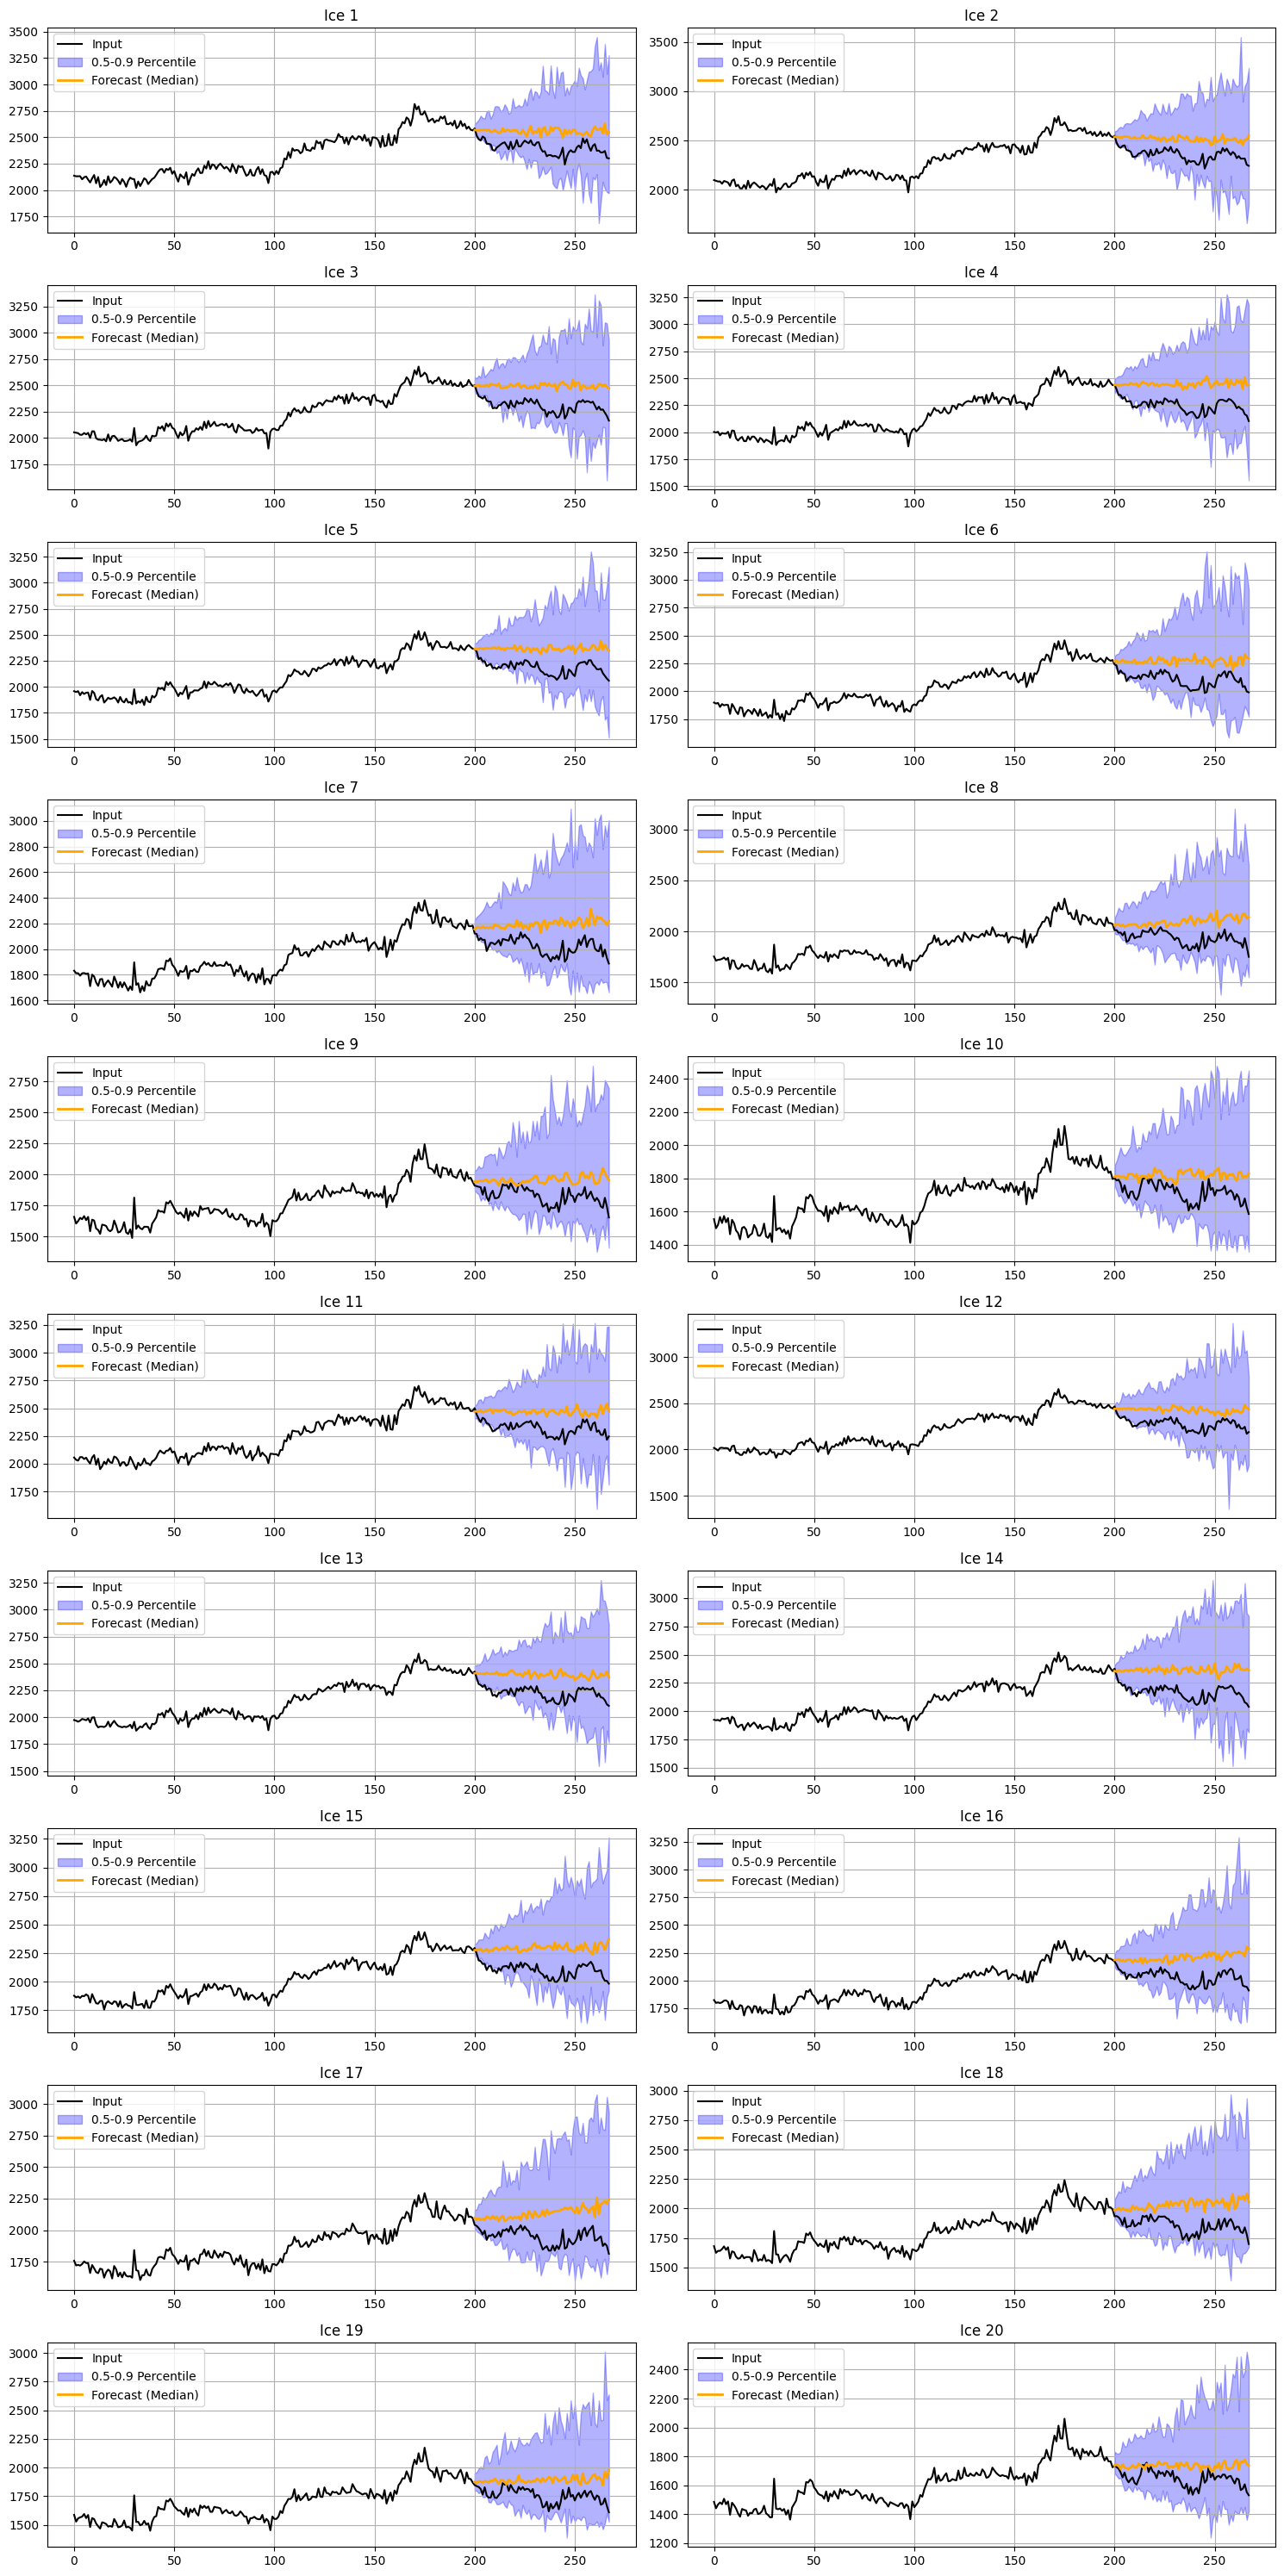

In [290]:
plot_moirai(inp, label, forecast,"Ice","moirai_ice_forecast")

## 3. GPS time series

In [44]:
# read data from data_gps_P395_relateive_position.csv
fname = "../data/data_gps_P395_relative_position.csv"
df = pd.read_csv(fname)
# convert dacimal year column to floats
df["decimal year"] = df["decimal year"].astype(float)

# the date format is in decimal years, convert it to datetime
# df["datetime"] = pd.to_datetime(df["decimal year"], format="%Y.%j")
# df.head()


# perform a running mean average to smooth the data
for ikey in df.keys()[1:]:
    df[ikey]=df[ikey].rolling(window=20).mean()

df=df.dropna()
df.head()

,decimal year,new delta e (m),new delta n (m),new delta v (m)
19,2006.1191,0.000501,-0.000668,0.000501
20,2006.1218,0.000554,-0.000639,0.000430
21,2006.1246,0.000612,-0.000548,0.000527
22,2006.1273,0.000644,-0.000513,0.000359
23,2006.1300,0.000653,-0.000306,-0.000209


In [45]:

sta_name = fname.split("/")[-1].split("_")[2]
print(sta_name)

P395


In [46]:
# take the first column "decimal year" and convert it to a datetime by taking the year before the comma, then multuply by 365.25 to get the days
df["datetime"] = pd.to_datetime((df["decimal year"] - 1970) * 365.25, unit='D', origin='1970-01-01')
# move the last to the first position
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

,datetime,decimal year,new delta e (m),new delta n (m),new delta v (m)
19,2006-02-13 12:01:50.159996416,2006.1191,0.000501,-0.000668,0.000501
20,2006-02-14 11:41:55.679996544,2006.1218,0.000554,-0.000639,0.000430
21,2006-02-15 12:14:36.960003200,2006.1246,0.000612,-0.000548,0.000527
22,2006-02-16 11:54:42.480003328,2006.1273,0.000644,-0.000513,0.000359
23,2006-02-17 11:34:48.000003456,2006.1300,0.000653,-0.000306,-0.000209


In [50]:
# first extract the new delta v(m) column and make a new dataframe
df2 = df[["datetime","new delta v (m)"]]
# put datetime as index
df2 = df2.set_index("datetime")
# rename the column to target
df2 = df2.rename(columns={"new delta v (m)": "target"})

In [53]:
inp

{'target': array([[ 0.0005015,  0.00043  ,  0.0005275, ..., -0.002406 , -0.002216 ,
         -0.0016085],
        [-0.0014715, -0.001387 , -0.0013515, ...,  0.009298 ,  0.0096285,
          0.0096115],
        [ 0.0092685,  0.0088885,  0.0093585, ...,  0.000962 ,  0.001453 ,
          0.001608 ],
        ...,
        [ 0.007905 ,  0.008435 ,  0.0088385, ...,  0.000523 ,  0.0013295,
          0.0014805],
        [ 0.001777 ,  0.0017765,  0.002395 , ...,  0.003241 ,  0.003047 ,
          0.0030955],
        [ 0.003384 ,  0.0033455,  0.003813 , ...,  0.0029685,  0.003057 ,
          0.003142 ]]),
 'start': PeriodIndex(['2006-02-13', '2006-12-10', '2007-10-06', '2008-08-01',
              '2009-05-28', '2010-03-25', '2011-01-25', '2011-11-21',
              '2012-09-16', '2013-07-13', '2014-05-09', '2015-03-05',
              '2015-12-30', '2016-10-26', '2017-08-29', '2018-06-25',
              '2019-04-21', '2020-02-15', '2020-12-13', '2021-10-11',
              '2022-08-10', '2023-06-07'

In [54]:
label

{'target': array([[ 0.0005015,  0.00043  ,  0.0005275, ...,  0.0021995,  0.001822 ,
          0.0015755],
        [-0.0014715, -0.001387 , -0.0013515, ..., -0.001814 , -0.001677 ,
         -0.0015875],
        [ 0.0092685,  0.0088885,  0.0093585, ..., -0.002053 , -0.0018685,
         -0.00148  ],
        ...,
        [ 0.007905 ,  0.008435 ,  0.0088385, ...,  0.0049615,  0.005169 ,
          0.0053525],
        [ 0.001777 ,  0.0017765,  0.002395 , ...,  0.009443 ,  0.0100305,
          0.010354 ],
        [ 0.003384 ,  0.0033455,  0.003813 , ...,  0.0051815,  0.005618 ,
          0.005764 ]]),
 'start': array([Period('2006-12-10', 'D'), Period('2007-10-06', 'D'),
        Period('2008-08-01', 'D'), Period('2009-05-28', 'D'),
        Period('2010-03-25', 'D'), Period('2011-01-25', 'D'),
        Period('2011-11-21', 'D'), Period('2012-09-16', 'D'),
        Period('2013-07-13', 'D'), Period('2014-05-09', 'D'),
        Period('2015-03-05', 'D'), Period('2015-12-30', 'D'),
        Period('20

batch size: 22
torch.Size([22, 100, 68]) 300 68 22


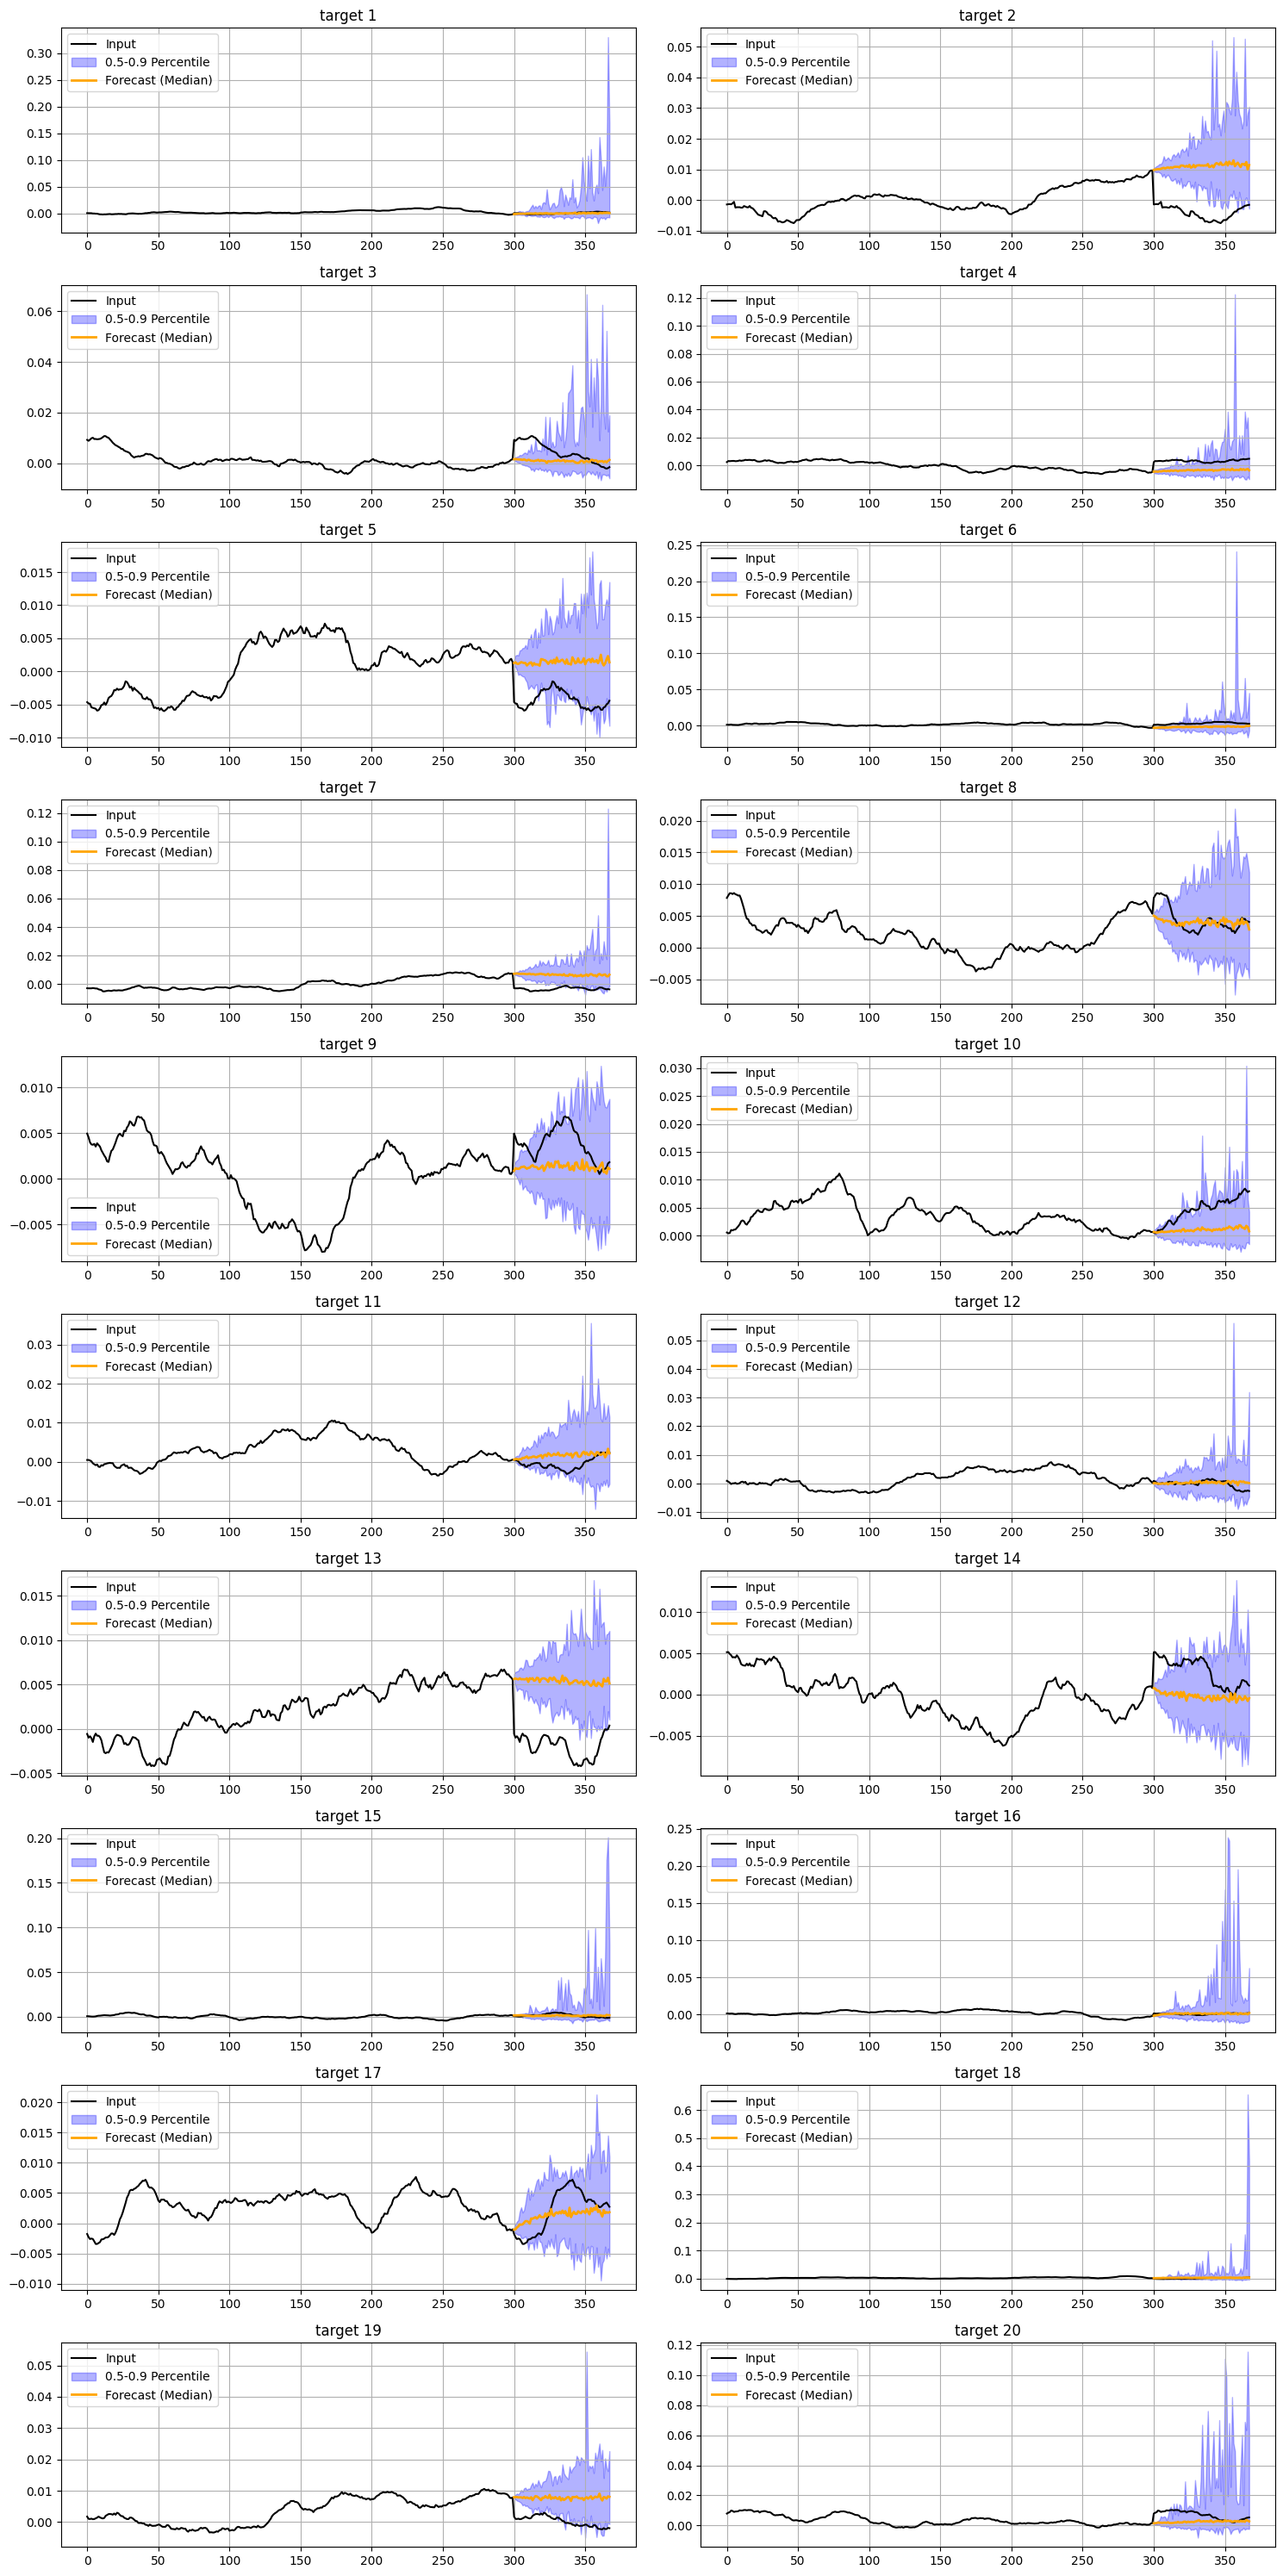

In [52]:
#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df2)-PDT)//CTX
print(f"batch size: {BSZ}") 
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_long_dataframe(df2, CTX, BSZ,PDT)

# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
print(forecast.shape,CTX,PDT,BSZ)
plot_moirai(inp, label, forecast,"target","moirai_forecast")


## 2.2 Loading from a _wide_ DataFrame

In [11]:
# # Load dataframe
# url_wide = (
#     "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
#     "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
# )
# df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

# df.head()

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708


In [12]:
# # Convert into GluonTS dataset
# ds = PandasDataset(dict(df))

# # Split into train/test set
# train, test_template = split(
#     ds, offset=-TEST
# )  # assign last TEST time steps as test set

# # Construct rolling window evaluation
# test_data = test_template.generate_instances(
#     prediction_length=PDT,  # number of time steps for each prediction
#     windows=TEST // PDT,  # number of windows in rolling window evaluation
#     distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
# )

In [13]:
# # Prepare model
# model = MoiraiForecast(
#     module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
#     prediction_length=PDT,
#     context_length=CTX,
#     patch_size=PSZ,
#     num_samples=100,
#     target_dim=1,
#     feat_dynamic_real_dim=ds.num_feat_dynamic_real,
#     past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
# )

# predictor = model.create_predictor(batch_size=BSZ)
# forecasts = predictor.predict(test_data.input)

# input_it = iter(test_data.input)
# label_it = iter(test_data.label)
# forecast_it = iter(forecasts)

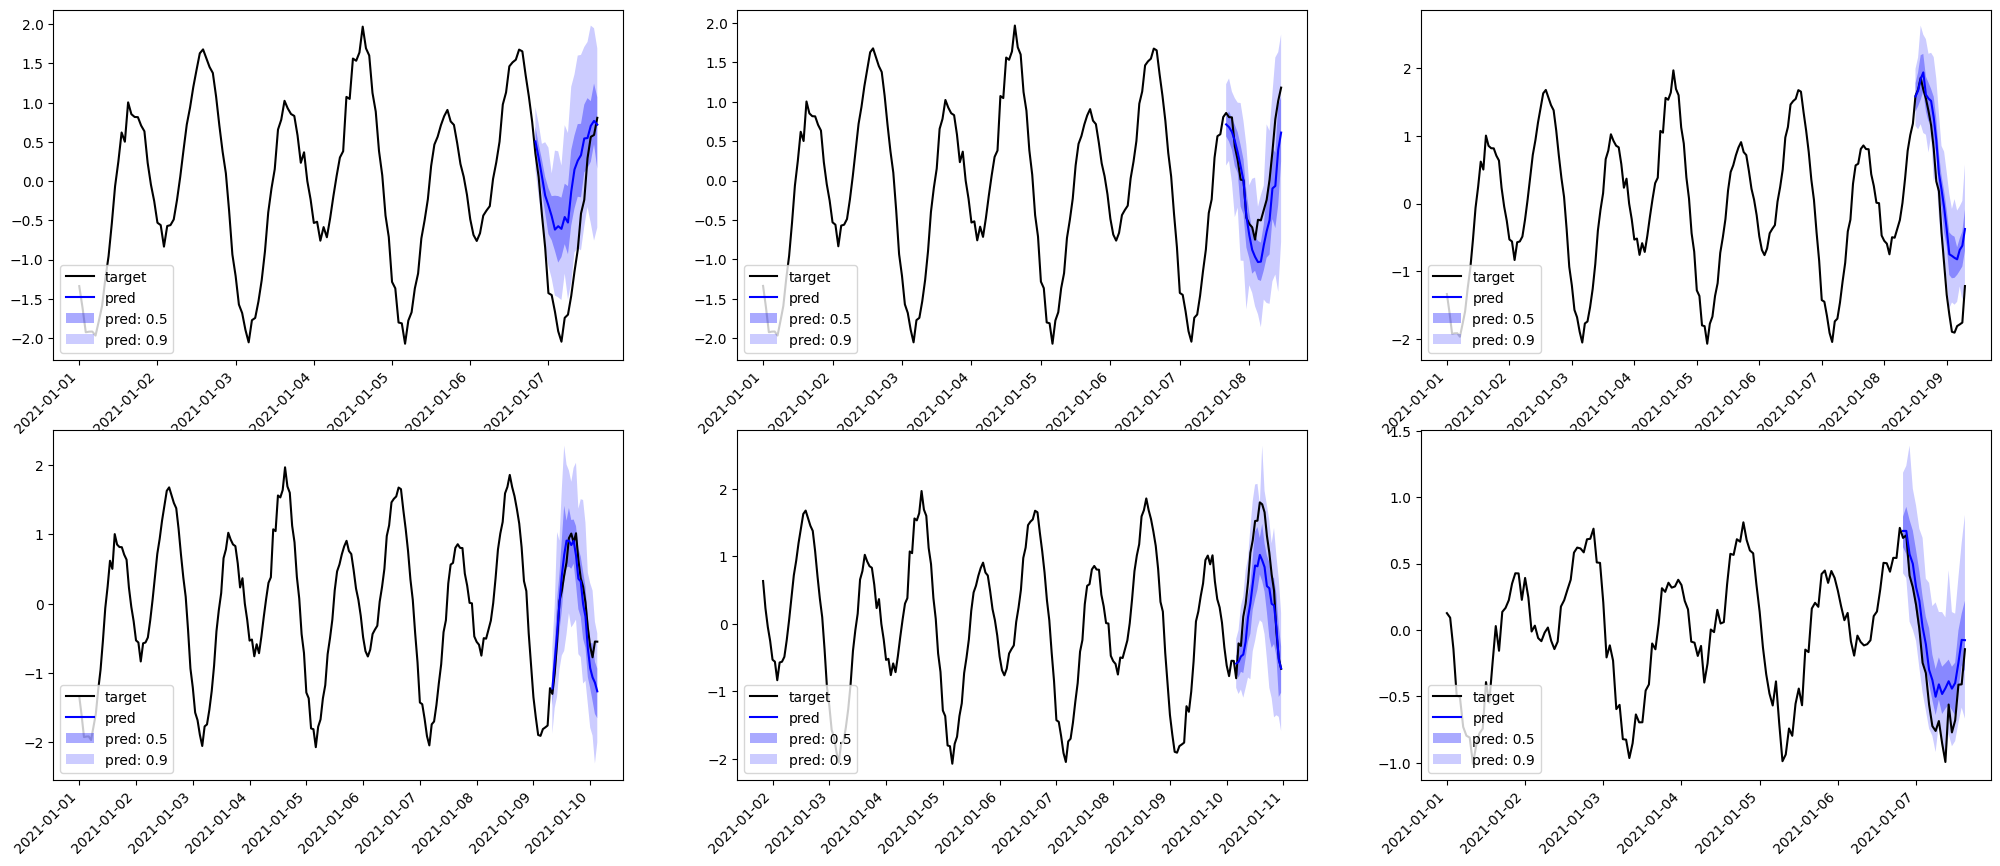

In [14]:
# # Make predictions
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
# plot_next_multi(
#     axes,
#     input_it,
#     label_it,
#     forecast_it,
#     context_length=200,
#     intervals=(0.5, 0.9),
#     dim=None,
#     name="pred",
#     show_label=True,
# )

# 2.3 Multivariate Forecasting

In [15]:
# # Load dataframe
# url_wide = (
#     "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
#     "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
# )
# df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

In [16]:
# # Convert into GluonTS dataset
# ds = PandasDataset(dict(df))

# # Group time series into multivariate dataset
# grouper = MultivariateGrouper(len(ds))
# multivar_ds = grouper(ds)

# # Split into train/test set
# train, test_template = split(
#     multivar_ds, offset=-TEST
# )  # assign last TEST time steps as test set

# # Construct rolling window evaluation
# test_data = test_template.generate_instances(
#     prediction_length=PDT,  # number of time steps for each prediction
#     windows=TEST // PDT,  # number of windows in rolling window evaluation
#     distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
# )

In [17]:
# # Prepare model
# model = MoiraiForecast(
#     module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
#     prediction_length=PDT,
#     context_length=CTX,
#     patch_size=PSZ,
#     num_samples=100,
#     target_dim=len(ds),
#     feat_dynamic_real_dim=ds.num_feat_dynamic_real,
#     past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
# )

# predictor = model.create_predictor(batch_size=BSZ)
# forecasts = predictor.predict(test_data.input)

# input_it = iter(test_data.input)
# label_it = iter(test_data.label)
# forecast_it = iter(forecasts)

In [18]:
# # Make predictions
# inp = next(input_it)
# label = next(label_it)
# forecast = next(forecast_it)

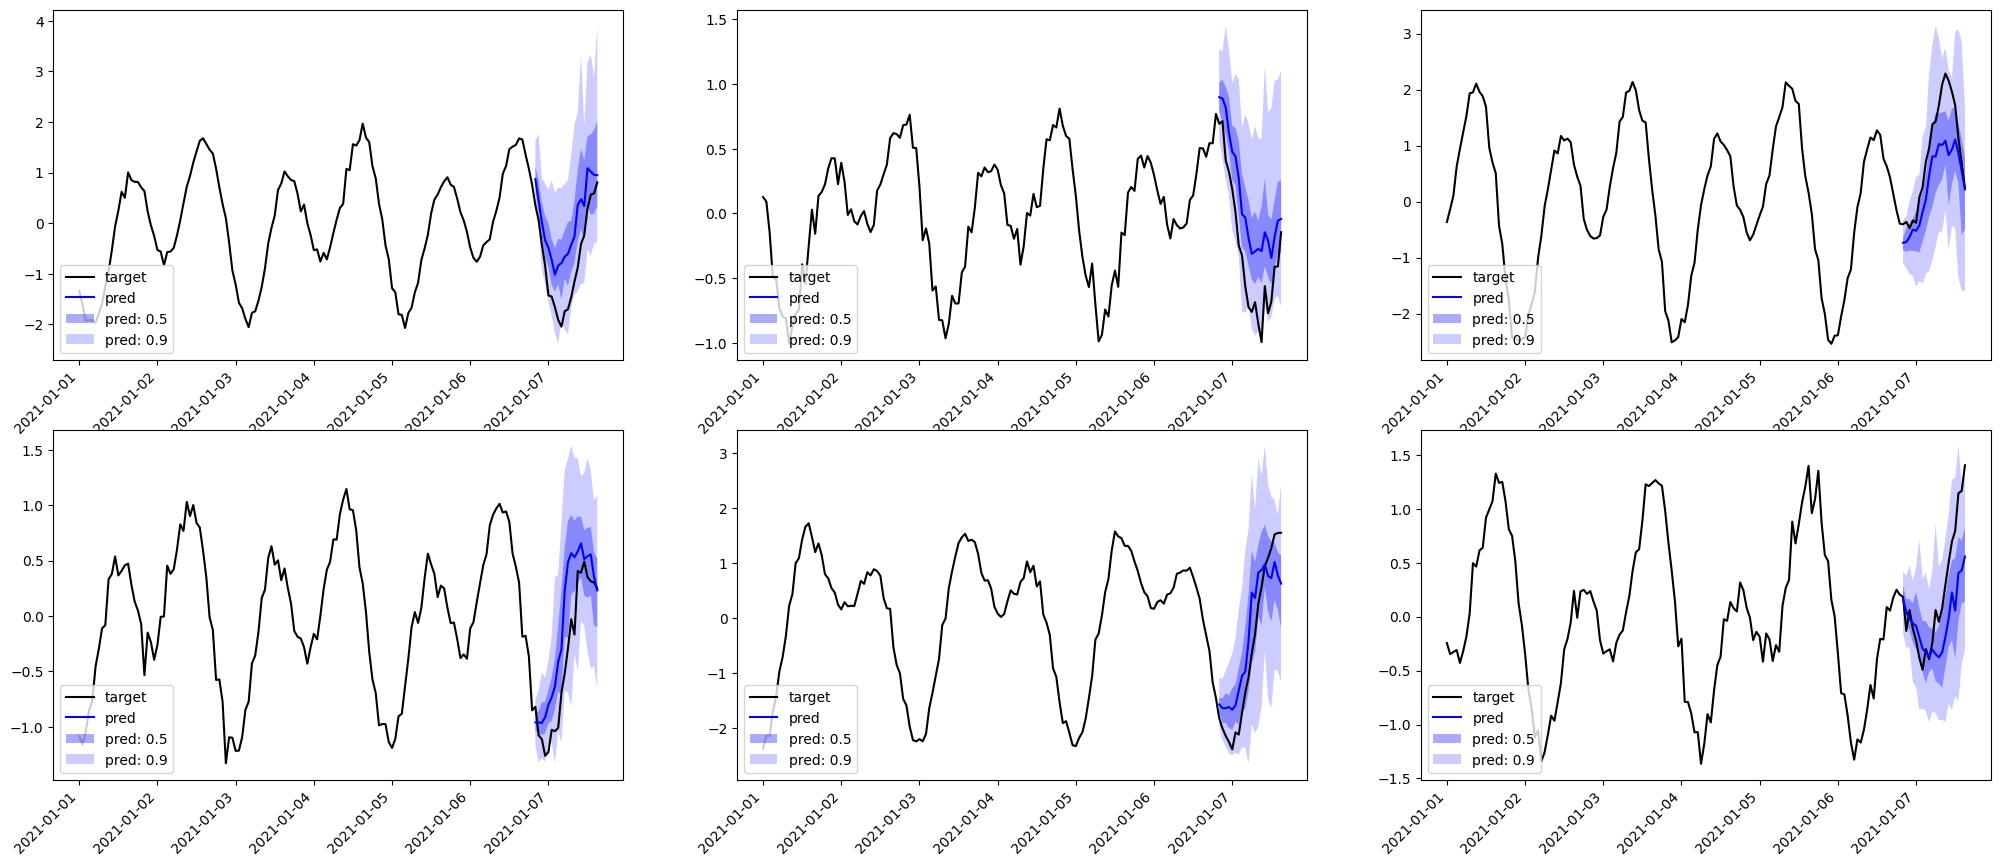

In [19]:
# # Visualize different dimensions
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
# for i, ax in enumerate(axes.flatten()):
#     plot_single(
#         inp,
#         label,
#         forecast,
#         context_length=200,
#         intervals=(0.5, 0.9),
#         dim=i,
#         ax=ax,
#         name="pred",
#         show_label=True,
#     )

## 2.4 Include dynamic features

<img src="img/extra_feature.png" alt="Drawing" style="width: 800px;"/>

Moirai supports adding additional covariates. Specifically, it could include past dynamic real features, and dynamic real feature that include features in the prediction window.

In [20]:
# # Load dataframe
# url = (
#     "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
#     "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
# )
# df = pd.read_csv(url, index_col=0, parse_dates=True)
# T = df.shape[0]
# df["dynamic_real_1"] = np.random.normal(size=T)
# df["past_dynamic_real_2"] = np.random.normal(size=T)

In [21]:
# ds = PandasDataset.from_long_dataframe(
#     df,
#     item_id="item_id",
#     past_feat_dynamic_real=["past_dynamic_real_2"],
#     feat_dynamic_real=["dynamic_real_1"],
# )

# # Split into train/test set
# train, test_template = split(
#     ds, offset=-TEST
# )  # assign last TEST time steps as test set

# # Construct rolling window evaluation
# test_data = test_template.generate_instances(
#     prediction_length=PDT,  # number of time steps for each prediction
#     windows=TEST // PDT,  # number of windows in rolling window evaluation
#     distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
# )

In [22]:
# # Prepare model
# model = MoiraiForecast(
#     module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
#     prediction_length=PDT,
#     context_length=CTX,
#     patch_size=PSZ,
#     num_samples=100,
#     target_dim=1,
#     feat_dynamic_real_dim=ds.num_feat_dynamic_real,
#     past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
# )

# predictor = model.create_predictor(batch_size=BSZ)
# forecasts = predictor.predict(test_data.input)

# input_it = iter(test_data.input)
# label_it = iter(test_data.label)
# forecast_it = iter(forecasts)

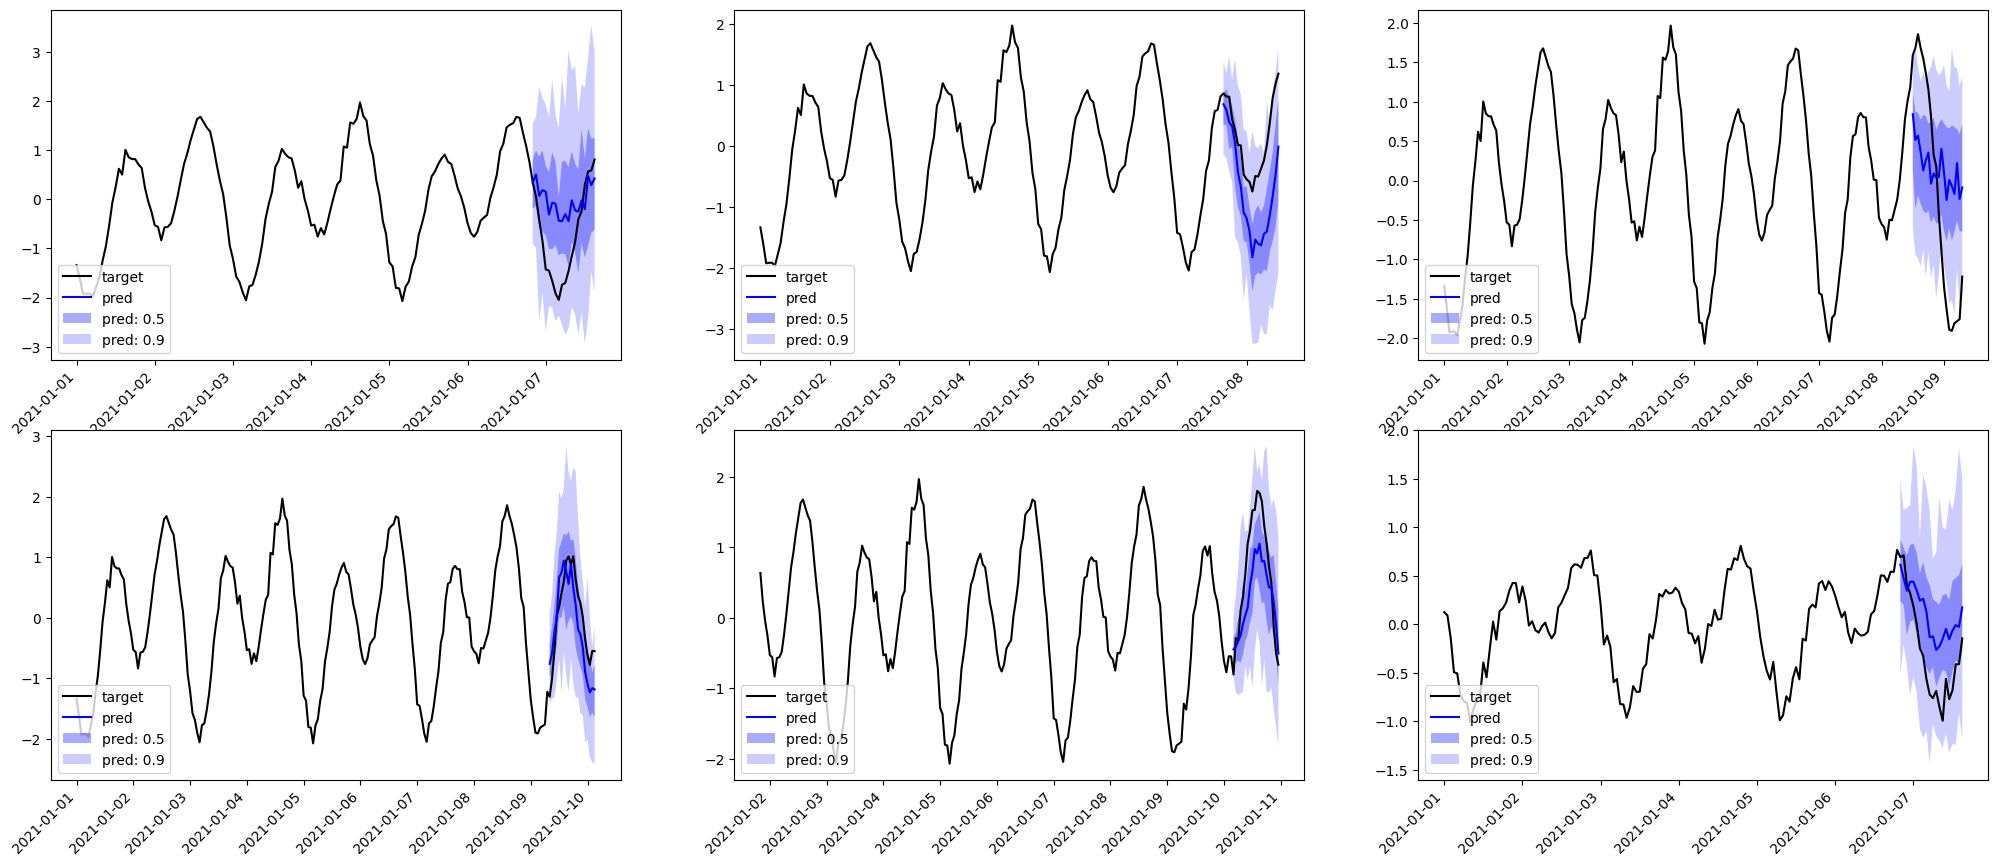

In [23]:
# # Make predictions
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
# plot_next_multi(
#     axes,
#     input_it,
#     label_it,
#     forecast_it,
#     context_length=200,
#     intervals=(0.5, 0.9),
#     dim=None,
#     name="pred",
#     show_label=True,
# )